# 初めてのニューラルネットワーク

このプロジェクトでは、初めてのニューラルネットワークを構築し、それを使って毎日のレンタサイクルの利用者数を予測します。コードの一部は提供していますが、ニューラルネットワークの実装は（ほぼ）皆さんにお任せしています。このプロジェクトを提出した後、自由にデータとモデルを調べてみてください。



In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## データの読み込みと準備

ニューラルネットワークを扱う上で重要なステップは、データを正しく準備することです。異なるスケールの変数があると、ネットワークが正しい重みを効率的に学習することが難しくなります。以下では、データの読み込みと準備のためのコードを書いています。詳細はこちらをご覧ください。

In [13]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [14]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## データを確認する
このデータセットは、2011年1月1日から2012年12月31日までの各日の各時間帯のライダー数を集計したものです。ライダーの数は、カジュアルライダーと登録ライダーに分けられ、cnt欄に合計されています。上の図は、データの最初の数行を示しています。

下の図は、データセットの最初の10日間ほどの自転車に乗る人の数をプロットしたものです。(データセットにちょうど24件のエントリがない日もあるので、正確には10日ではありません)。ここでは1時間ごとのレンタル料金を見ることができます。このデータはかなり複雑ですね。週末は全体的に利用者数が少なく、平日は自転車での通勤・通学時に利用者が急増します。上のデータを見ると、気温、湿度、風速などの情報もあり、これらがライダーの数に影響を与えていると考えられます。これらすべてがライダーの数に影響を与えると考えられます。

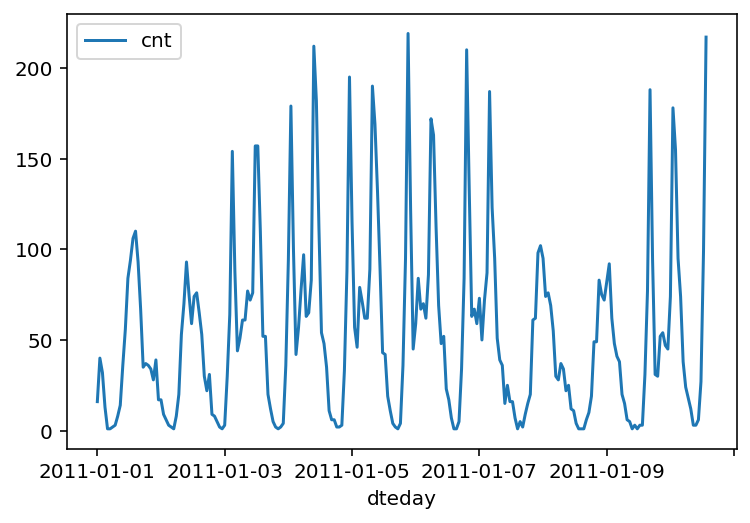

In [15]:
rides[:24*10].plot(x='dteday', y='cnt')

### ダミー変数
ここでは、季節、天気、月などのカテゴリー変数があります。これらをモデルに含めるためには、バイナリのダミー変数を作る必要があります。Pandasでは、`get_dummies()`のおかげで簡単にできます。


In [16]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### 対象変数のスケーリング
ネットワークの学習を容易にするために、各連続変数を標準化します。つまり、平均値がゼロ、標準偏差が1になるように、変数をシフトしてスケーリングします。

スケーリングファクタは保存され、ネットワークを予測に使用する際に逆戻りすることができます。

In [17]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# スケーリングを辞書に格納し、後で変換できるようにする
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### データをトレーニングセット、テストセット、検証セットに分割する

ここでは、ネットワークの学習後にテストセットとして使用するために、過去約21日間のデータを保存します。このデータを使って予測を行い、実際のライダー数と比較します。

In [18]:
# 過去約21日間のデータを保存 
test_data = data[-21*24:]

# データセットからテストデータを削除する 
data = data[:-21*24]

# データをフィーチャーとターゲットに分ける
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

データを2つのセットに分け、1つはトレーニング用、もう1つはネットワークのトレーニング中に行う検証用とします。これは時系列データなので、過去のデータで学習し、将来のデータ（検証セット）で予測してみます。

In [19]:
# 残っているデータのうち、直近の60日分ほどを検証用のセットとして持ち出す
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## ネットワーク構築の時間

以下、ネットワークを構築します。私たちは構造を構築しました。ネットワークにフォワードパスとバックワードパスの両方を実装します。また、ハイパーパラメータ（学習率、隠れユニットの数、トレーニングパスの数）を設定します。

<img src="assets/neural_network.png" width=300px>

このネットワークには，隠れ層と出力層の2つの層があります．隠れ層では、活性化にシグモイド関数を使用します。出力層はノードを1つだけ持ち、回帰に使用されます。ノードの出力はノードの入力と同じです。つまり、活性化関数は$f(x)=x$となります。入力信号を受け取って出力信号を生成するが、閾値を考慮している関数を活性化関数と呼ぶ。ネットワークの各層で、各ニューロンの出力を計算していきます。ある層の出力はすべて、次の層のニューロンの入力になります。このプロセスを「順方向の伝搬」と呼びます。

ニューラルネットワークでは、入力層から出力層へと信号を伝搬させるために重みを使用します。また、重みを使って、エラーを出力からネットワークに逆方向に伝搬させ、重みを更新します。これを *backpropagation* と呼びます。

> ヒント：**バックプロパゲーションの実装には、出力活性化関数の微分（$f(x) = x$）が必要です。微積分に慣れていない方は、この関数は、$y = x$という方程式に相当します。この式の傾きは何でしょうか？それが $f(x)$ の導関数です。

以下、あなたには次のような課題があります。
1. 活性化関数として使用するシグモイド関数を実装する。__init__`の`self.activation_function`にシグモイド関数を設定してください。
2. フォワードパスを `train` メソッドに実装する。
3. 3. `train` メソッドにバックプロパゲーションアルゴリズムを実装し、出力誤差を計算する。
4. run`メソッドにフォワードパスを実装する。

  

In [20]:
#############
# my_answers.pyファイルでは、TODOセクションを指定通りに記入します。
#############

from my_answers import NeuralNetwork

In [21]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## ユニットテスト

これらのユニットテストを実行して、ネットワークの実装が正しく行われているかどうかをチェックします。これにより、ネットワークのトレーニングを開始する前に、ネットワークが正しく実装されていることを確認することができます。プロジェクトに合格するためには、これらのテストがすべて成功する必要があります。

In [22]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # データ読み込みのユニットテスト
    ##########
    
    def test_data_path(self):
        # データセットのファイルパスが変更されていないことを確認する
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # データフレームが読み込まれたかどうかのテスト
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # ネットワーク機能のユニットテスト
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # 活性化関数がシグモイドであることを調べる
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # トレーニング時にウェイトが正しく更新されているかのテスト
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # 実行方法の正しさをテスト
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.018s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## ネットワークのトレーニング

ここでは、ネットワークのハイパーパラメータを設定します。ここでの戦略は、トレーニングセットでのエラーが少なく、かつデータにオーバーフィットしないようなハイパーパラメータを見つけることです。ネットワークの学習時間が長すぎたり、隠れノードが多すぎたりすると、学習セットに特化しすぎてしまい、検証セットに汎化できなくなります。つまり、トレーニングセットの損失が減ると、検証セットの損失が増え始めるのです。

また、ネットワークの学習には、SGD（Stochastic Gradient Descent）と呼ばれる手法を使用します。これは、各トレーニングパスにおいて、データセット全体を使用する代わりに、データのランダムなサンプルを取得するというものです。通常の勾配降下法よりも多くのトレーニングパスを使用しますが、各パスははるかに高速です。その結果、ネットワークをより効率的に学習することができます。SGD については後ほど詳しく説明します。

### 反復回数の選択
ここでは、ネットワークの学習に使用する学習データのサンプルバッチの数を指定します。反復回数が多いほど、モデルのデータへの適合性が高くなります。しかし、反復回数が多すぎると、このプロセスのリターンが急激に減少し、計算機資源を浪費することになります。 ここでは、ネットワークの学習損失が少なく、検証損失が最小となるような数値を求めます。理想的な反復回数は、検証損失が減少しなくなった直後に停止するレベルです。

### 学習率の選択
ウェイトの更新の大きさを調整します。この値が大きすぎると、重みが爆発的に増加し、ネットワークがデータに適合しなくなる傾向があります。通常は0.1から始めるのが良いと思いますが、学習率を実質的にn_recordsで割る場合は、学習率を1から始めてみてください。なお、学習率が低いほど、重み更新のステップが小さくなり、ニューラルネットワークが収束するまでの時間が長くなります。

### 隠れノードの数の選択
全ての重みが最適化されたモデルでは、隠れノードの数が多いほど、モデルの予測精度が高くなります。 しかし、隠れノードの数が多くなると、モデルの重みを最適化するのが難しくなり、最適でない重みではオーバーフィッティングになる可能性が高くなります。オーバーフィッティングが起こると、モデルは真のパターンを学習する代わりにトレーニングデータを記憶してしまい、見たことのないデータに対してうまく一般化できなくなります。 

いくつかの異なる数値を試して、パフォーマンスにどのような影響を与えるかを確認してください。ネットワークの性能を示す指標として、損失の辞書を見ることができます。隠れユニットの数が少なすぎると、モデルが学習するのに十分なスペースが得られず、高すぎると学習の方向性の選択肢が多すぎてしまいます。ここでのコツは、選択する隠しユニットの数の適切なバランスを見つけることです。 一般的に、最適な隠れノードの数は、入力ノードと出力ノードの数の中間であることがわかります。


In [23]:
import sys

####################
### myanswers.pyファイルでハイパーパラメータを設定します。 ###
####################

from my_answers import iterations, learning_rate, hidden_nodes, output_nodes


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # トレーニングデータセットから128件のレコードをランダムに抽出します。
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']
                             
    network.train(X, y)
    
    # トレーニングの進捗状況を印刷する
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.074 ... Validation loss: 0.167

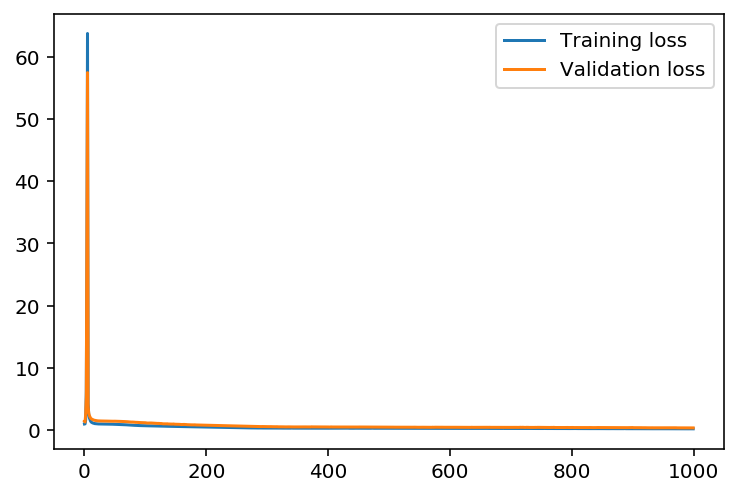

In [ ]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## 予測結果の確認

ここでは、テストデータを使って、自分のネットワークがどれだけデータをモデル化しているかを確認します。ここで何かが完全に間違っている場合は、ネットワークの各ステップが正しく実装されていることを確認してください

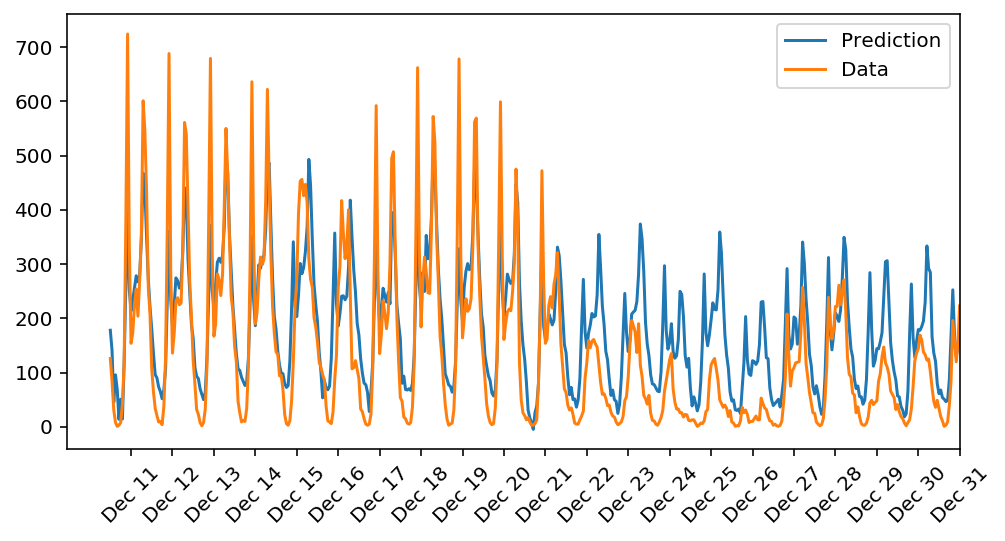

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)